In [68]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
import pickle as pkl
import tensorflow as tf

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/drive/My Drive/CustomerChurn_dataset.csv')

In [18]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


In [20]:
df["Churn"].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

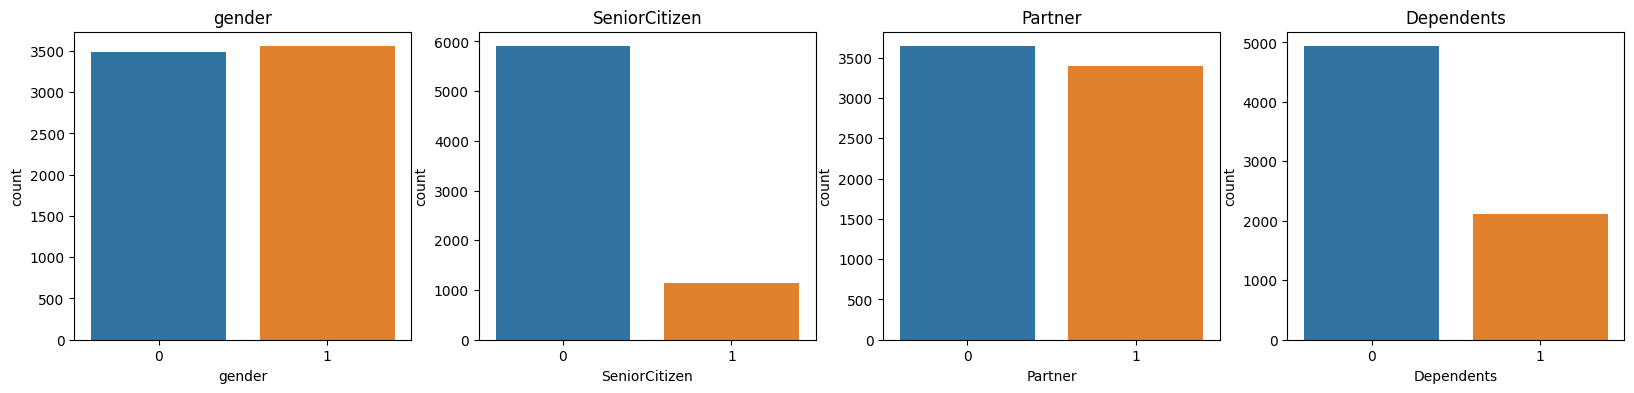

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cols = ['gender','SeniorCitizen',"Partner","Dependents"]
numerical = cols

plt.figure(figsize=(20,4))

for i, col in enumerate(numerical):
    ax = plt.subplot(1, len(numerical), i+1)
    sns.countplot(x=str(col), data=df)
    ax.set_title(f"{col}")

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

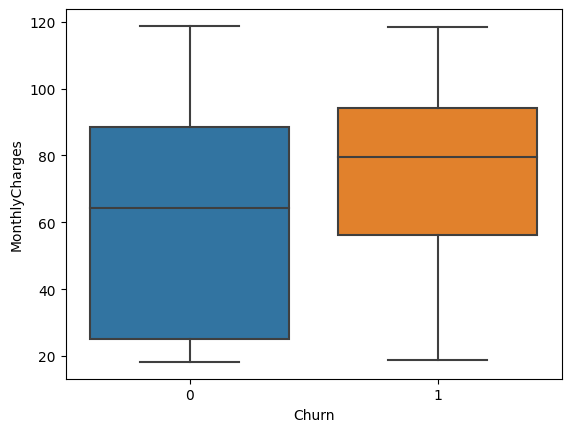

In [22]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)

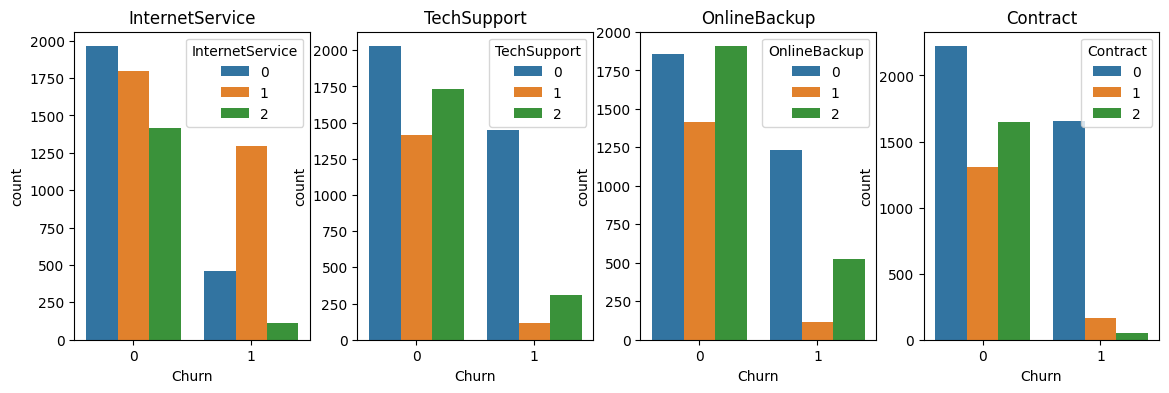

In [23]:
cols = ['InternetService',"TechSupport","OnlineBackup","Contract"]

plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x ="Churn", hue = str(col), data = df)
    ax.set_title(f"{col}")

In [8]:
columns_to_drop = ['customerID']
df = df.drop(columns_to_drop, axis=1)

In [9]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

In [10]:
encoder = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = encoder.fit_transform(df[column])

In [31]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [38]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Create a DataFrame from the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


In [41]:
X_scaled_df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,-1.009559,-0.439916,1.034530,-0.654012,-1.277445,-3.054010,0.062723,-1.183234,-0.918838,1.242550,-1.027910,-0.925262,-1.113495,-1.121405,-0.828207,0.829798,0.398558,-1.160323,-0.994971
1,0.990532,-0.439916,-0.966622,-0.654012,0.066327,0.327438,-0.991588,-1.183234,1.407321,-1.029919,1.245111,-0.925262,-1.113495,-1.121405,0.371271,-1.205113,1.334863,-0.259629,-0.173876
2,0.990532,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,-0.991588,-1.183234,1.407321,1.242550,-1.027910,-0.925262,-1.113495,-1.121405,-0.828207,0.829798,1.334863,-0.362660,-0.960399
3,0.990532,-0.439916,-0.966622,-0.654012,0.514251,-3.054010,0.062723,-1.183234,1.407321,-1.029919,1.245111,1.396299,-1.113495,-1.121405,0.371271,-1.205113,-1.474052,-0.746535,-0.195400
4,-1.009559,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,-0.991588,0.172250,-0.918838,-1.029919,-1.027910,-0.925262,-1.113495,-1.121405,-0.828207,0.829798,0.398558,0.197365,-0.941193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.990532,-0.439916,1.034530,1.529024,-0.340876,0.327438,1.117034,-1.183234,1.407321,-1.029919,1.245111,1.396299,1.146547,1.138411,0.371271,0.829798,1.334863,0.665992,-0.129281
7039,-1.009559,-0.439916,1.034530,1.529024,1.613701,0.327438,1.117034,0.172250,-0.918838,1.242550,1.245111,-0.925262,1.146547,1.138411,0.371271,0.829798,-0.537747,1.277533,2.242808
7040,-1.009559,-0.439916,1.034530,1.529024,-0.870241,-3.054010,0.062723,-1.183234,1.407321,-1.029919,-1.027910,-0.925262,-1.113495,-1.121405,-0.828207,0.829798,0.398558,-1.168632,-0.855182
7041,0.990532,2.273159,1.034530,-0.654012,-1.155283,0.327438,1.117034,0.172250,-0.918838,-1.029919,-1.027910,-0.925262,-1.113495,-1.121405,-0.828207,0.829798,1.334863,0.320338,-0.872777


In [42]:
rf = RandomForestClassifier(random_state=46)
rf.fit(X_scaled_df, y)


RandomForestClassifier(random_state=46)

In [43]:
feature_importance_rf = pd.Series(rf.feature_importances_, index=X.columns)
selected_features_rf = feature_importance_rf.nlargest(15).index
X_selected_rf = X[selected_features_rf]

In [39]:
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer_1 = Dense(32, activation='relu')(input_layer)
hidden_layer_2 = Dense(24, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(12, activation='relu')(hidden_layer_2)
output_layer = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=input_layer, outputs=output_layer)

In [45]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
177/177 [==============================] - 3s 4ms/step - loss: 0.7139 - accuracy: 0.5034 - val_loss: 0.6519 - val_accuracy: 0.6608
Epoch 2/100
177/177 [==============================] - 2s 9ms/step - loss: 0.6130 - accuracy: 0.7121 - val_loss: 0.5743 - val_accuracy: 0.7410
Epoch 3/100
177/177 [==============================] - 2s 11ms/step - loss: 0.5523 - accuracy: 0.7371 - val_loss: 0.5216 - val_accuracy: 0.7445
Epoch 4/100
177/177 [==============================] - 2s 10ms/step - loss: 0.5125 - accuracy: 0.7433 - val_loss: 0.4860 - val_accuracy: 0.7566
Epoch 5/100
177/177 [==============================] - 2s 12ms/step - loss: 0.4875 - accuracy: 0.7528 - val_loss: 0.4632 - val_accuracy: 0.7700
Epoch 6/100
177/177 [==============================] - 1s 8ms/step - loss: 0.4711 - accuracy: 0.7698 - val_loss: 0.4480 - val_accuracy: 0.7750
Epoch 7/100
177/177 [==============================] - 2s 10ms/step - loss: 0.4601 - accuracy: 0.7783 - val_loss: 0.4373 - val_accuracy: 0.

In [46]:
_, accuracy = model.evaluate(X_train, y_train)
accuracy*100
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.4f}')

45/45 [==============================] - 0s 2ms/step - loss: 0.4029 - accuracy: 0.8141
Test Loss: 0.4029
Test Accuracy: 81.4053


In [51]:
!pip install keras-tuner

import keras_tuner
from tensorflow import keras

In [52]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(X_train.shape[1],)))

    # Tune the number of hidden layers and units
    for i in range(hp.Int('num_hidden_layers', min_value=1, max_value=4)):
        model.add(keras.layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=96, step=32),
                             activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
        )

    return model

In [53]:
build_model(keras_tuner.HyperParameters())

In [54]:
tuner = keras_tuner.Hyperband(
  hypermodel=build_model,
  objective='val_accuracy',
  max_epochs=100,
  factor=3,
  directory='tuning_dir',
  project_name='samples')

In [55]:
tuner.search(X_train, y_train, epochs=30 ,validation_data=(X_test, y_test))

Trial 254 Complete [00h 01m 15s]
val_accuracy: 0.8119233250617981

Best val_accuracy So Far: 0.8261178135871887
Total elapsed time: 00h 45m 48s


In [56]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
num_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 32, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 32, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 32, 'sampling': 'linear'}
activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_3 (Int)
{'default': None

In [57]:
tuner.results_summary()


Results summary
Results in tuning_dir/samples
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0189 summary
Hyperparameters:
num_hidden_layers: 1
units_0: 96
activation_0: tanh
lr: 0.00032997284234501643
units_1: 96
activation_1: tanh
units_2: 32
activation_2: relu
units_3: 32
activation_3: tanh
tuner/epochs: 12
tuner/initial_epoch: 4
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 0167
Score: 0.8261178135871887

Trial 0203 summary
Hyperparameters:
num_hidden_layers: 1
units_0: 96
activation_0: tanh
lr: 0.00032997284234501643
units_1: 96
activation_1: tanh
units_2: 32
activation_2: relu
units_3: 32
activation_3: tanh
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0189
Score: 0.8261178135871887

Trial 0236 summary
Hyperparameters:
num_hidden_layers: 2
units_0: 96
activation_0: tanh
lr: 0.00040063918764481445
units_1: 64
activation_1: relu
units_2: 32
activation_2: relu
units_3: 32
activation_3: relu
tuner/epochs: 34


In [60]:
model = tf.keras.Model(...)
checkpoint = tf.train.Checkpoint(model)

# Save a checkpoint to /tmp/training_checkpoints-{save_counter}. Every time
# checkpoint.save is called, the save counter is increased.
save_path = checkpoint.save('/tmp/training_checkpoints')

# Restore the checkpointed values to the `model` object.
checkpoint.restore(save_path)


In [61]:
best_model = tuner.get_best_models(num_models=2)[0]

In [62]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                1920      
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 2017 (7.88 KB)
Trainable params: 2017 (7.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
test_accuracy = best_model.evaluate(X_test, y_test)[1]
print(f"Test Accuracy: {test_accuracy:.4f}")

45/45 [==============================] - 0s 2ms/step - loss: 0.4039 - accuracy: 0.8261
Test Accuracy: 0.8261


In [64]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [65]:
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred>0.5).astype(int)


# Calculate AUC
accuracy = accuracy_score(y_test,y_pred_binary )
auc_score = roc_auc_score(y_test,y_pred)
print("Initial Model Accuracy:", accuracy)
print("Initial Model Auc Score:", auc_score)

45/45 [==============================] - 0s 1ms/step
Initial Model Accuracy: 0.8261178140525195
Initial Model Auc Score: 0.8578920264577101


In [66]:
best_model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
with open('/content/drive/MyDrive/label_encoder.pkl', 'wb') as file:
    pkl.dump(encoder, file)

In [69]:
with open('scaler.pkl','wb') as file:
  pkl.dump(sc,file)

In [70]:
with open('label_encoder.pkl', 'wb') as file:
    pkl.dump(encoder, file)

In [71]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: Churn
Non-Null Count  Dtype
--------------  -----
7043 non-null   int64
dtypes: int64(1)
memory usage: 55.1 KB


In [73]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


In [74]:
X_selected_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TotalCharges      7043 non-null   float64
 1   MonthlyCharges    7043 non-null   float64
 2   tenure            7043 non-null   int64  
 3   Contract          7043 non-null   int64  
 4   PaymentMethod     7043 non-null   int64  
 5   OnlineSecurity    7043 non-null   int64  
 6   TechSupport       7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   gender            7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  PaperlessBilling  7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  Partner           7043 non-null   int64  
 13  MultipleLines     7043 non-null   int64  
 14  SeniorCitizen     7043 non-null   int64  
dtypes: float64(2), int64(13)
memory usage: 825.5 KB


In [75]:
X_selected_rf

,TotalCharges,MonthlyCharges,tenure,Contract,PaymentMethod,OnlineSecurity,TechSupport,InternetService,gender,OnlineBackup,PaperlessBilling,DeviceProtection,Partner,MultipleLines,SeniorCitizen
0,29.85,29.85,1,0,2,0,0,0,0,2,1,0,1,1,0
1,1889.50,56.95,34,1,3,2,0,0,1,0,0,2,0,0,0
2,108.15,53.85,2,0,3,2,0,0,1,2,1,0,0,0,0
3,1840.75,42.30,45,1,0,2,2,0,1,0,0,2,0,1,0
4,151.65,70.70,2,0,2,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1990.50,84.80,24,1,3,2,2,0,1,0,1,2,1,2,0
7039,7362.90,103.20,72,1,1,0,0,1,0,2,1,2,1,2,0
7040,346.45,29.60,11,0,2,2,0,0,0,0,1,0,1,1,0
7041,306.60,74.40,4,0,3,0,0,1,1,0,1,0,1,2,1
